hy, ha még egyszer csinálnám én biztos h kiszedném a képkimentős meg hálózat konstrukciós részt külön python fájlokba, és itt csak importálgatnám, h a notebookba csak a lényeg legyen és ne kelljen végiggörgetni minden 'helper' sz*rt :)

In [0]:
!git clone https://github.com/DeepTesla/deep_learning_hf dl

Cloning into 'dl'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 354 (delta 1), reused 7 (delta 1), pack-reused 338
Receiving objects: 100% (354/354), 575.96 MiB | 34.11 MiB/s, done.
Resolving deltas: 100% (78/78), done.
Checking out files: 100% (47/47), done.


In [0]:
%cd dl

/content/dl


In [0]:
import cv2
import os
import logging
from multiprocessing.pool import ThreadPool
import numpy as np
import tensorflow as tf

In [0]:
tf.__version__

'1.15.0'

In [0]:
def rmdir(dir_path):
    if os.path.exists(dir_path):
        entries = os.scandir(dir_path)
        for entry in entries:
            if entry.is_dir():
                rmdir(os.path.join(dir_path, entry))
            else:
                os.remove(os.path.join(dir_path, entry))
        time.sleep(0.5)
        os.rmdir(dir_path)

def remove_dir(dir_path: str) -> None:
    """
    Deletes a directory and all of its contents recursively.
    :param dir_path: path to the direcory to delete
    :return: None
    """
    if os.path.exists(dir_path):
        contents = os.scandir(dir_path) # contents is of type List[DirEntry]
        for content in contents:
            if content.is_dir():
                remove_dir(os.path.join(dir_path, content))
            else:
                os.remove(content)
        os.rmdir(dir_path)

In [0]:
# remove_dir(os.path.join("/content", "dl", "images"))

In [0]:
logging.basicConfig(level=logging.DEBUG, format='[%(levelname)s]: %(message)s')


class VideoLoader():
    video_res = (640, 480)

    def __init__(self, video_dir_path: os.path, video_type: str):
        if not os.path.exists(video_dir_path):
            raise Exception(f'Path doesn\'t exist!\n{video_dir_path}')
        self.video_dir_path = video_dir_path
        self.video_type = video_type
        self.videos = {}
        self.load_videos()

    def load_videos(self) -> None:
        logging.info(f'loading video files from:\n{self.video_dir_path}')
        with os.scandir(self.video_dir_path) as entries:
            for e in entries:
                *name, ext = e.name.split('.')
                if ext == 'avi':
                    # get the sequence number
                    seq, type_, *_ = name[0].split('_')
                    if type_ == self.video_type:
                        seq = int(seq)
                        self.videos[seq] = os.path.join(self.video_dir_path, e.name)
                        logging.info(e.name)

    def to_array(self) -> np.array:
        """Downscales the video to 160x120, converts each frame to a tensor, collects the tensors.
        Returns an array of shape (no_frames, 160, 120, 3)"""
        logging.info(f'converting {len(self.videos)} videos to np.arrays')
        result = []
        new_res = (160, 120)
        for i in range(min(self.videos), max(self.videos)+1):
            # TODO remove preemptive stop
            # if i == 2:
            #      break
            vc = cv2.VideoCapture(self.videos[i])
            frame_cnt = 0
            while True:
                ret, frame_orig = vc.read()
                if frame_orig is None:
                    break
                frame_new = cv2.resize(frame_orig, new_res)
                # frame_new = cv2.cvtColor(frame_new, cv2.COLOR_BGR2RGB)
                result.append(frame_new)
                frame_cnt += 1
            vc.release()
        result = np.array(result).astype(np.float16)
        return result / 255.0

orig_dir = os.path.join(os.getcwd(), 'data')
train_dir = os.path.join(orig_dir, 'train')
valid_dir = os.path.join(orig_dir, 'validation')

train_x_loader = VideoLoader(train_dir, 'orig')
train_y_loader = VideoLoader(train_dir, 'annot')
valid_x_loader = VideoLoader(valid_dir, 'orig')
valid_y_loader = VideoLoader(valid_dir, 'annot')

pool = ThreadPool(processes=4)
train_x = pool.apply_async(train_x_loader.to_array)
train_y = pool.apply_async(train_y_loader.to_array)
valid_x = pool.apply_async(valid_x_loader.to_array)
valid_y = pool.apply_async(valid_y_loader.to_array)
train_x = train_x.get()
train_y = train_y.get()
valid_x = valid_x.get()
valid_y = valid_y.get()

assert len(train_x) == len(train_y)

# split_ratio = 0.8
# split_idx = int(split_ratio * len(train_x_a))
# train_x = train_x_a[:split_idx]
# train_y = train_y_a[:split_idx]
# valid_x = train_x_a[split_idx:]
# valid_y = train_y_a[split_idx:]

# for the labels, we only need 1 component
# train_y = train_y.T[0].T
# valid_y = valid_y.T[0].T

tx_cnt = len(train_x)
ty_cnt = len(train_y)
vx_cnt = len(valid_x)
vy_cnt = len(valid_y)

print('Done with initializing the datasets.')
logging.debug(f'train_x shape {train_x.shape}')
logging.debug(f'train_y shape {train_y.shape}')
logging.debug(f'valid_x shape {valid_x.shape}')
logging.debug(f'valid_y shape {valid_y.shape}')

[INFO]: loading video files from:
/content/dl/data/train
[INFO]: 00004_orig_pp.avi
[INFO]: 00003_orig_pp.avi
[INFO]: 00005_orig_pp.avi
[INFO]: 00006_orig_pp.avi
[INFO]: 00000_orig_pp.avi
[INFO]: 00008_orig_pp.avi
[INFO]: 00002_orig_pp.avi
[INFO]: 00007_orig_pp.avi
[INFO]: 00001_orig_pp.avi
[INFO]: loading video files from:
/content/dl/data/train
[INFO]: 00008_annot_pp.avi
[INFO]: 00003_annot_pp.avi
[INFO]: 00006_annot_pp.avi
[INFO]: 00005_annot_pp.avi
[INFO]: 00000_annot_pp.avi
[INFO]: 00002_annot_pp.avi
[INFO]: 00001_annot_pp.avi
[INFO]: 00004_annot_pp.avi
[INFO]: 00007_annot_pp.avi
[INFO]: loading video files from:
/content/dl/data/validation
[INFO]: 00010_orig_pp.avi
[INFO]: 00009_orig_pp.avi
[INFO]: loading video files from:
/content/dl/data/validation
[INFO]: 00010_annot_pp.avi
[INFO]: 00009_annot_pp.avi
[INFO]: converting 9 videos to np.arrays
[INFO]: converting 9 videos to np.arrays
[INFO]: converting 2 videos to np.arrays
[INFO]: converting 2 videos to np.arrays
[DEBUG]: train_

Done with initializing the datasets.


In [0]:
# write images
images_dir = os.path.join(os.getcwd(), 'images')
img_train_x_dir = os.path.join(images_dir, 'train_x')
img_train_y_dir = os.path.join(images_dir, 'train_y')
img_valid_x_dir = os.path.join(images_dir, 'valid_x')
img_valid_y_dir = os.path.join(images_dir, 'valid_y') 

rmdir(images_dir)
os.mkdir(images_dir)
os.mkdir(img_train_x_dir)
os.mkdir(img_train_y_dir)
os.mkdir(img_valid_x_dir)
os.mkdir(img_valid_y_dir)

def save_images(img_list, img_dir):
    for idx, img in enumerate(img_list):
        cv2.imwrite(os.path.join(img_dir, f'{idx:06d}.png'), (img*255).astype(np.int16))

save_images(train_x, img_train_x_dir)
save_images(train_y, img_train_y_dir)
save_images(valid_x, img_valid_x_dir)
save_images(valid_y, img_valid_y_dir)

del train_x, train_y, valid_x, valid_y  # free up memory, stupid solution

In [0]:
kernel_size = (6,8)
filters = 64

model = tf.keras.models.Sequential()

# ENCODER

model.add(tf.keras.layers.InputLayer(input_shape=(120, 160, 3)))    # RGB image goes in
# --------------------
model.add(tf.keras.layers.Conv2D(filters=filters,
                                 kernel_size=kernel_size,
                                 strides=1,
                                 padding='same',
                                 use_bias=True,
                                 bias_initializer=tf.keras.initializers.constant(value=0.0)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.Conv2D(filters=filters,
                                 kernel_size=kernel_size,
                                 strides=1,
                                 padding='same',
                                 use_bias=True,
                                 bias_initializer=tf.keras.initializers.constant(value=0.0)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# --------------------
model.add(tf.keras.layers.Conv2D(filters=filters*2,
                                 kernel_size=kernel_size,
                                 strides=1,
                                 padding='same',
                                 use_bias=True,
                                 bias_initializer=tf.keras.initializers.constant(value=0.0)))
model.add(tf.keras.layers.BatchNormalization())       
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.Conv2D(filters=filters*2,
                                 kernel_size=kernel_size,
                                 strides=1,
                                 padding='same',
                                 use_bias=True,
                                 bias_initializer=tf.keras.initializers.constant(value=0.0)))
model.add(tf.keras.layers.BatchNormalization())       
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# --------------------
model.add(tf.keras.layers.Conv2D(filters=filters*4,
                                 kernel_size=kernel_size,
                                 strides=1,
                                 padding='same',
                                 use_bias=True,
                                 bias_initializer=tf.keras.initializers.constant(value=0.0)))
model.add(tf.keras.layers.BatchNormalization())       
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.Conv2D(filters=filters*4,
                                 kernel_size=kernel_size,
                                 strides=1,
                                 padding='same',
                                 use_bias=True,
                                 bias_initializer=tf.keras.initializers.constant(value=0.0)))
model.add(tf.keras.layers.BatchNormalization())       
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# --------------------

# DECODER

# --------------------
model.add(tf.keras.layers.UpSampling2D(size=2,
                                       interpolation='nearest'))
model.add(tf.keras.layers.Conv2D(filters=filters*4,
                                 kernel_size=kernel_size,
                                 strides=1,
                                 padding='same',
                                 use_bias=True,
                                 bias_initializer=tf.keras.initializers.constant(value=0.0)))
model.add(tf.keras.layers.BatchNormalization())       
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.Conv2D(filters=filters*4,
                                 kernel_size=kernel_size,
                                 strides=1,
                                 padding='same',
                                 use_bias=True,
                                 bias_initializer=tf.keras.initializers.constant(value=0.0)))
model.add(tf.keras.layers.BatchNormalization())       
model.add(tf.keras.layers.ReLU())

# --------------------
model.add(tf.keras.layers.UpSampling2D(size=2,
                                       interpolation='nearest'))
model.add(tf.keras.layers.Conv2D(filters=filters*2,
                                 kernel_size=kernel_size,
                                 strides=1,
                                 padding='same',
                                 use_bias=True,
                                 bias_initializer=tf.keras.initializers.constant(value=0.0)))
model.add(tf.keras.layers.BatchNormalization())       
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.Conv2D(filters=filters*2,
                                 kernel_size=kernel_size,
                                 strides=1,
                                 padding='same',
                                 use_bias=True,
                                 bias_initializer=tf.keras.initializers.constant(value=0.0)))
model.add(tf.keras.layers.BatchNormalization())       
model.add(tf.keras.layers.ReLU())

# --------------------
model.add(tf.keras.layers.UpSampling2D(size=2,
                                       interpolation='nearest'))
model.add(tf.keras.layers.Conv2D(filters=filters,
                                 kernel_size=kernel_size,
                                 strides=1,
                                 padding='same',
                                 use_bias=True,
                                 bias_initializer=tf.keras.initializers.constant(value=0.0)))
model.add(tf.keras.layers.BatchNormalization())       
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.Conv2D(filters=filters,
                                 kernel_size=kernel_size,
                                 strides=1,
                                 padding='same',
                                 use_bias=True,
                                 bias_initializer=tf.keras.initializers.constant(value=0.0)))
model.add(tf.keras.layers.BatchNormalization())       
model.add(tf.keras.layers.ReLU())

# --------------------

# model.add(tf.keras.layers.Conv2D(filters=2,
#                                  kernel_size=kernel_size,
#                                  strides=1,
#                                  padding='same',
#                                  use_bias=True,
#                                  activation='softmax',
#                                  bias_initializer=tf.keras.initializers.constant(value=0.0)))
model.add(tf.keras.layers.Dense(units=1,
                                activation='sigmoid',
                                use_bias=True

))
model.add(tf.keras.layers.Reshape((120,160)))


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


[WARNING]: From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
# import tensorflow_probability as tfp
# tfd = tfp.distributions

# def loss(y_pred, y_true):
#     print(y_pred)
#     return y_pred

In [0]:
# a = []
# p = [[.2, .8],[.2, .8],[.2, .8]]
# dist = tfd.Multinomial(total_count=1., probs=p)
# # for _ in range(100):
# sample = dist.sample()
# sample_max = tf.argmax(sample, axis=1)
# with tf.Session() as sess:  
#     e = sample.eval()
#     e_max = sample_max.eval()
#     print(e)
#     print(e_max)
    # a.append(e)
# print(e)
# print(np.unique(e, return_counts=True)) 

[[0. 1.]
 [1. 0.]
 [1. 0.]]
[0 1 1]


In [0]:
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="binary_crossentropy", metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 160, 64)      9280      
_________________________________________________________________
batch_normalization (BatchNo (None, 120, 160, 64)      256       
_________________________________________________________________
re_lu (ReLU)                 (None, 120, 160, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 160, 64)      196672    
_________________________________________________________________
batch_normalization_1 (Batch (None, 120, 160, 64)      256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 120, 160, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 80, 64)        0

In [0]:
def train_generator(batch_size):
    while True:
        # read batch size random indexed images
        t_idxs = np.random.randint(0, tx_cnt, batch_size)
        x_shape = (batch_size, 120, 160, 3)
        y_shape = (batch_size, 120, 160)
        # y_shape = (batch_size, 120, 160, 3)
        x = np.zeros(shape=x_shape, dtype=np.float32)
        y = np.zeros(shape=y_shape, dtype=np.float32)
        for i, idx in enumerate(t_idxs):
            filename = f'{idx:06d}.png'
            x[i] = cv2.imread(os.path.join(img_train_x_dir, filename))
            y[i] = cv2.imread(os.path.join(img_train_y_dir, filename))[:,:,0]    # cv2.imread() returns a (width,height,channels) shaped ndarray, img being grayscale we need only 1 channel  
            # y[i] = cv2.imread(os.path.join(img_train_y_dir, filename)) 
        
        yield (x/255,y/255)

def valid_generator(batch_size): 
    while True:
        # read batch size random indexed images
        t_idxs = np.random.randint(0, vx_cnt, batch_size)
        x_shape = (batch_size, 120, 160, 3)
        y_shape = (batch_size, 120, 160)
        # y_shape = (batch_size, 120, 160, 3)
        x = np.zeros(shape=x_shape, dtype=np.float32)
        y = np.zeros(shape=y_shape, dtype=np.float32)
        for i, idx in enumerate(t_idxs):
            filename = f'{idx:06d}.png'
            x[i] = cv2.imread(os.path.join(img_valid_x_dir, filename))
            y[i] = cv2.imread(os.path.join(img_valid_y_dir, filename))[:,:,0]    # cv2.imread() returns a (width,height,channels) shaped ndarray, img being grayscale we need only 1 channel  
            # y[i] = cv2.imread(os.path.join(img_valid_y_dir, filename))
        
        yield (x/255,y/255)

steps_per_epoch = 20
train_batch_size = int(tx_cnt / steps_per_epoch)
valid_batch_size = int(vx_cnt / steps_per_epoch)
tg = train_generator(train_batch_size)
vg = valid_generator(valid_batch_size)
a,b = next(tg)
print(np.array(a).shape)
print(a[0][0][:10])
print(np.array(b).shape)
print(b[0][0][:10])

(69, 120, 160, 3)
[[1.         0.81960785 0.4509804 ]
 [1.         0.81960785 0.4509804 ]
 [1.         0.81960785 0.4509804 ]
 [1.         0.81960785 0.4509804 ]
 [1.         0.81960785 0.4509804 ]
 [1.         0.81960785 0.4509804 ]
 [1.         0.81960785 0.4509804 ]
 [1.         0.81960785 0.4509804 ]
 [1.         0.81960785 0.4509804 ]
 [1.         0.81960785 0.4509804 ]]
(69, 120, 160)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [0]:
path_checkpoint = 'checkpoint.keras'
callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=path_checkpoint,
                                                          monitor='val_loss',
                                                          verbose=1,
                                                          save_weights_only=True,
                                                          save_best_only=True)

callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=20, verbose=1)
callback_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                          factor=0.1,
                                                          patience=10,
                                                          verbose=1,
                                                          min_rl=1e-5)

model.fit_generator(
    generator=tg,
    steps_per_epoch=steps_per_epoch,
    epochs=1000,
    verbose=1,
    validation_data=vg,
    validation_steps=steps_per_epoch,
    callbacks=[callback_checkpoint, callback_reduce_lr, callback_early_stopping]
)

Epoch 1/1000
20/20 [==============================] - 11s 573ms/step - loss: 4.1151 - acc: 0.7313

Epoch 00001: val_loss improved from inf to 4.11512, saving model to checkpoint.keras
20/20 [==============================] - 148s 7s/step - loss: 0.4256 - acc: 0.7985 - val_loss: 4.1151 - val_acc: 0.7313
Epoch 2/1000
20/20 [==============================] - 8s 420ms/step - loss: 3.6866 - acc: 0.7380

Epoch 00002: val_loss improved from 4.11512 to 3.68665, saving model to checkpoint.keras
20/20 [==============================] - 120s 6s/step - loss: 0.2286 - acc: 0.9134 - val_loss: 3.6866 - val_acc: 0.7380
Epoch 3/1000
20/20 [==============================] - 8s 420ms/step - loss: 3.5868 - acc: 0.7299

Epoch 00003: val_loss improved from 3.68665 to 3.58675, saving model to checkpoint.keras
20/20 [==============================] - 120s 6s/step - loss: 0.1652 - acc: 0.9345 - val_loss: 3.5868 - val_acc: 0.7299
Epoch 4/1000
20/20 [==============================] - 8s 421ms/step - loss: 1.6788

KeyboardInterrupt: ignored

In [0]:
# load best model
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [0]:
from google.colab.patches import cv2_imshow

def predict(num):
    # idxs = np.random.randint(0, tx_cnt, size=num)
    # print(f'idx: {idxs}')
    # for i in idxs:
    #     o = train_x[i]
    #     a = train_y[i]
    #     p = model.predict(np.expand_dims(o, axis=0))[0]
    #     img = np.concatenate((o, a, p), axis=1)
    #     cv2_imshow(img*255)
    x, y = next(vg)
    x = x[:5]
    y = y[:5]
    p = [model.predict(np.expand_dims(x[i], axis=0))[0] for i in range(len(x))]
    for r in range(len(x)):
        a = np.array(x[r])*255
        b = np.zeros(shape=x[r].shape)
        c = np.zeros(shape=x[r].shape)
        for i in range(120):
            for j in range(160):
                b[i,j,0] = y[r][i,j]
                b[i,j,1] = y[r][i,j]
                b[i,j,2] = y[r][i,j]
                c[i,j,0] = p[r][i,j]
                c[i,j,1] = p[r][i,j]
                c[i,j,2] = p[r][i,j]
        b = b*255
        # for channel in range(3):
        #     p[r][:, :, channel] = scaler.fit_transform(p[r][:, :, channel])
        c = c*255
        # t = p[r].reshape(120*160, 3)
        img = np.concatenate((a, b, c), axis=1)
        cv2_imshow(img)
    print(np.around(p[r], 2))

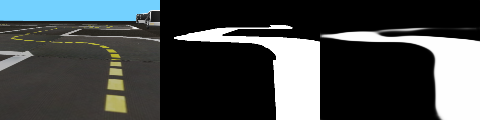

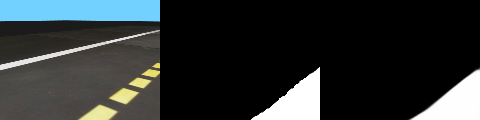

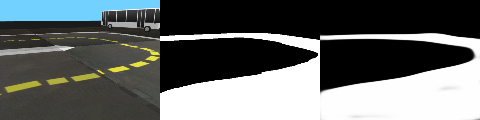

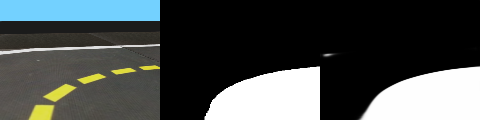

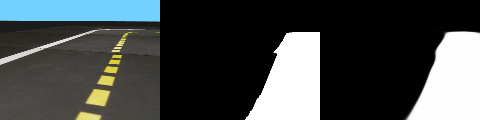

[[0.   0.   0.   ... 0.   0.   0.01]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 1.   1.   1.  ]
 [0.   0.   0.   ... 1.   1.   1.  ]
 [0.   0.   0.   ... 1.   1.   1.  ]]


In [0]:
predict(5)